# Explore here

In [136]:
# Your code here
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import KNNImputer
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import xgboost as xgb
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import *
from sklearn.ensemble import BaggingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import joblib

In [137]:
df = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/linear-regression-project-tutorial/main/medical_insurance_cost.csv",sep=",")
df.head(5)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [138]:
df.shape

(1338, 7)

In [139]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [140]:
n_unicos = df.nunique()
n_unicos

age           47
sex            2
bmi          548
children       6
smoker         2
region         4
charges     1337
dtype: int64

In [141]:
# Comprobamos el porcentaje de anuncios que presentan al menos un valor faltante
df.isnull().any(axis=1).mean()*100

np.float64(0.0)

In [142]:
# Factorizar los datos no numericos
df["sex"] = pd.factorize(df["sex"])[0]
df["smoker"] = pd.factorize(df["smoker"])[0]
df["region"] = pd.factorize(df["region"])[0]

In [143]:
#Invertimos los valores de smoker porque el modelo lo estaba tomando como algo positivo.
df['smoker'] = 1 - df['smoker']

In [144]:
# Eliminar las columnas 'sex' y 'region'
df = df.drop(columns=['sex', 'region'])
df['charges'] = np.log(df['charges'])

In [146]:
X = df.drop(['charges'], axis=1)
y = df['charges']

X = sm.add_constant(X)
model = sm.OLS(y, X)

# Ajustar el modelo a los datos
results = model.fit()
print(results.summary())

# Instancia de la influencia y obtención de la distancia de cook para cada observación
cooks_distance = model.get_influence().cooks_distance

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     1068.
Date:                Mon, 27 Jan 2025   Prob (F-statistic):               0.00
Time:                        19:51:10   Log-Likelihood:                -825.01
No. Observations:                1338   AIC:                             1660.
Df Residuals:                    1333   BIC:                             1686.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.9828      0.070    100.151      0.0

AttributeError: 'OLS' object has no attribute 'get_influence'

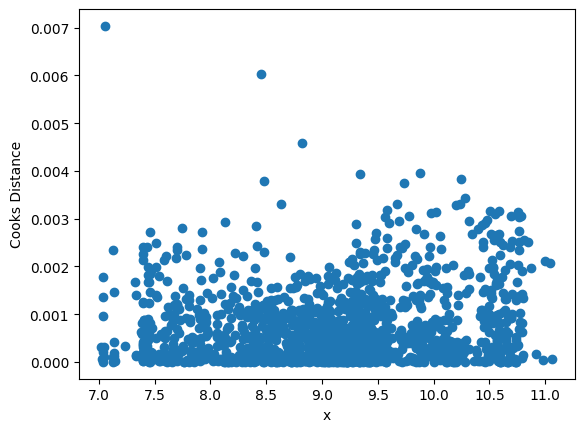

In [147]:
plt.scatter(df.charges, cooks_distance[0])
plt.xlabel('x')
plt.ylabel('Cooks Distance')
plt.show()

In [148]:
# Punto de corte para la distancia de cook
pto_corte = 4/len(df)

# Viviendas por encima del pto de corte
len(np.where(cooks_distance[0]>pto_corte)[0])

25

In [149]:
np.where(cooks_distance[0]>pto_corte)

(array([   0,   11,   14,   32,   39,   69,   71,   98,   99,  166, 1245,
        1265, 1272, 1282, 1284, 1288, 1301, 1307, 1313, 1317, 1318, 1321,
        1323, 1332, 1337]),)

In [150]:
df1 = df.drop(np.where(cooks_distance[0]>pto_corte)[0])

In [151]:
X = df1.drop(['charges'], axis=1)
y = df1['charges']


In [152]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [153]:
# Usamos xgb para conocer la importancia de las características
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42).fit(X_train, y_train)
df = pd.DataFrame({'Feature':X_train.columns, 'Importance':xgb_model.feature_importances_*100})
df = df.sort_values(by='Importance', ascending=False)
df

,Feature,Importance
3,smoker,88.552658
0,age,7.231777
2,children,2.610038
1,bmi,1.605530


In [154]:
X_train.corr()

,age,bmi,children,smoker
age,1.000000,0.131685,0.050645,-0.025681
bmi,0.131685,1.000000,0.007454,0.020122
children,0.050645,0.007454,1.000000,0.003150
smoker,-0.025681,0.020122,0.003150,1.000000


<Axes: >

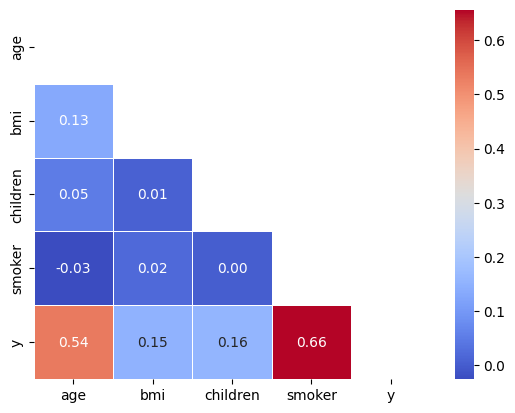

In [155]:
X_corr = X_train.copy()
X_corr['y'] = y_train
corr = X_corr.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')

In [156]:
# Identificar las variables binarias
binary_cols = X_train[(X_train == 0)|(X_train == 1)].dropna(axis=1).columns
binary_cols

Index(['smoker'], dtype='object')

In [157]:
# seleciono las columnas que no son binarias
X_train_num = X_train.drop(binary_cols, axis=1)
X_test_num = X_test.drop(binary_cols, axis=1)

In [158]:
# Instancio la clase del escalador y lo ajusto con los datos de entrenamiento
scaler = StandardScaler().fit(X_train_num)

In [159]:
# Trasnformamos los datos numericos con el escalador ajustado
X_ẗrain_num_sc = scaler.transform(X_train_num)
X_ẗest_num_sc = scaler.transform(X_test_num)

In [160]:
X_train_sc = pd.concat([pd.DataFrame(X_ẗrain_num_sc, columns = X_train_num.columns), X_train[binary_cols].reset_index(drop=True)], axis=1)
X_test_sc = pd.concat([pd.DataFrame(X_ẗest_num_sc, columns = X_test_num.columns), X_test[binary_cols].reset_index(drop=True)], axis=1)

In [161]:
X_train_sc

,age,bmi,children,smoker
0,-1.440841,-0.378892,-0.071055,0
1,0.342210,-0.527540,-0.071055,0
2,-0.941587,0.364345,0.786501,1
3,0.056922,1.740160,-0.071055,0
4,0.556176,-1.900051,-0.071055,0
...,...,...,...,...
1045,1.055430,0.090173,-0.928610,0
1046,0.770142,1.053078,-0.071055,0
1047,-0.371011,2.015983,-0.071055,0
1048,0.770142,0.909386,-0.928610,0


In [162]:
y_train

149      7.518889
913      8.939449
373     10.493639
209      8.796356
1004     9.062715
          ...    
1105     9.243672
1140     9.110302
1312     8.419858
870      9.042846
1136     8.938993
Name: charges, Length: 1050, dtype: float64

In [163]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [164]:
logreg = LinearRegression() 
modelo = logreg.fit(X_train_sc, y_train)

In [167]:
# Instanciamos el estimador
estimator = ExtraTreesRegressor()

# Definimos el espacio de búsqueda de los hp
param_dist = {'n_estimators':[30,40,50], 'max_depth':np.arange(10, 100, 10)}

# Realizamos la búsqueda aleatoria
random_search = RandomizedSearchCV(estimator, param_dist, n_iter=5, random_state=42, n_jobs=-1, scoring='neg_root_mean_squared_error', verbose=2, cv=5)
random_search.fit(X_train_sc, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ......................max_depth=30, n_estimators=50; total time=   0.1s
[CV] END ......................max_depth=30, n_estimators=50; total time=   0.1s
[CV] END ......................max_depth=30, n_estimators=50; total time=   0.1s
[CV] END ......................max_depth=30, n_estimators=50; total time=   0.1s
[CV] END ......................max_depth=30, n_estimators=50; total time=   0.1s
[CV] END ......................max_depth=50, n_estimators=40; total time=   0.1s
[CV] END ......................max_depth=50, n_estimators=40; total time=   0.1s
[CV] END ......................max_depth=50, n_estimators=40; total time=   0.1s
[CV] END ......................max_depth=40, n_estimators=30; total time=   0.1s
[CV] END ......................max_depth=50, n_estimators=40; total time=   0.1s
[CV] END ......................max_depth=40, n_estimators=30; total time=   0.1s
[CV] END ......................max_depth=50, n_es

RandomizedSearchCV(cv=5, estimator=ExtraTreesRegressor(), n_iter=5, n_jobs=-1,
                   param_distributions={'max_depth': array([10, 20, 30, 40, 50, 60, 70, 80, 90]),
                                        'n_estimators': [30, 40, 50]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [168]:
random_search.best_score_

np.float64(-0.42084720082542465)

In [169]:
random_search.best_params_

{'n_estimators': 30, 'max_depth': np.int64(10)}

In [170]:
param_dist = {'n_estimators':[20,30,40,50], 'max_depth':[1,5,10]}

# Realizamos la búsqueda por fuerza bruta
grid_search = GridSearchCV(estimator, param_dist, verbose=3)
grid_search.fit(X_train_sc, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END ......max_depth=1, n_estimators=20;, score=0.436 total time=   0.0s
[CV 2/5] END ......max_depth=1, n_estimators=20;, score=0.409 total time=   0.0s
[CV 3/5] END ......max_depth=1, n_estimators=20;, score=0.364 total time=   0.0s
[CV 4/5] END ......max_depth=1, n_estimators=20;, score=0.491 total time=   0.0s
[CV 5/5] END ......max_depth=1, n_estimators=20;, score=0.421 total time=   0.0s
[CV 1/5] END ......max_depth=1, n_estimators=30;, score=0.436 total time=   0.0s
[CV 2/5] END ......max_depth=1, n_estimators=30;, score=0.409 total time=   0.0s
[CV 3/5] END ......max_depth=1, n_estimators=30;, score=0.364 total time=   0.0s
[CV 4/5] END ......max_depth=1, n_estimators=30;, score=0.491 total time=   0.0s
[CV 5/5] END ......max_depth=1, n_estimators=30;, score=0.421 total time=   0.0s
[CV 1/5] END ......max_depth=1, n_estimators=40;, score=0.436 total time=   0.0s
[CV 2/5] END ......max_depth=1, n_estimators=40;

GridSearchCV(estimator=ExtraTreesRegressor(),
             param_grid={'max_depth': [1, 5, 10],
                         'n_estimators': [20, 30, 40, 50]},
             verbose=3)

In [171]:
grid_search.best_params_

{'max_depth': 5, 'n_estimators': 50}

In [172]:
y_pred_train = grid_search.best_estimator_.predict(X_train_sc)
y_pred_test = grid_search.best_estimator_.predict(X_test_sc)
y_train_eu = y_train 
y_test_eu = y_test

In [173]:
def calculate_metrics(y_train, y_test, y_pred_train, y_pred_test):
    # Calcular las métricas para entrenamiento
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mape_train = mean_absolute_percentage_error(y_train, y_pred_train)*100
    r2_train = r2_score(y_train, y_pred_train)

    # Calcular las métricas para test
    mae_test = mean_absolute_error(y_test, y_pred_test)
    mape_test = mean_absolute_percentage_error(y_test, y_pred_test)*100
    r2_test = r2_score(y_test, y_pred_test)

    # Calcular las diferencias
    mae_diff = mae_test - mae_train
    mape_diff = mape_test - mape_train
    r2_diff = r2_test - r2_train

    # Crear el DataFrame
    metrics_df = pd.DataFrame({
        'MAE': [mae_train, mae_test, mae_diff],
        'MAPE': [mape_train, mape_test, mape_diff],
        'R2': [r2_train, r2_test, r2_diff]
    }, index=['Train', 'Test', 'Difference'])

    return metrics_df

In [174]:
calculate_metrics(y_train_eu, y_test_eu, y_pred_train, y_pred_test)

,MAE,MAPE,R2
Train,0.207588,2.304437,0.827238
Test,0.201195,2.218767,0.845968
Difference,-0.006392,-0.085670,0.018730
